# Effect of generating multiple poses

This notebook explores the effect on the succes rate when generating multiple poses per structure using **Fred** and **Hybrid**.

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.utils import resample

In [2]:
sns.set() # Setting seaborn as default style even if use only matplotlib

In [3]:
OUT_DIR = Path("../pics")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
fred_results = pd.read_csv("../data/fred_results.csv", index_col=0)
hybrid_results = pd.read_csv("../data/hybrid_results.csv", index_col=0)
posit_results = pd.read_csv("../data/posit_results.csv", index_col=0)

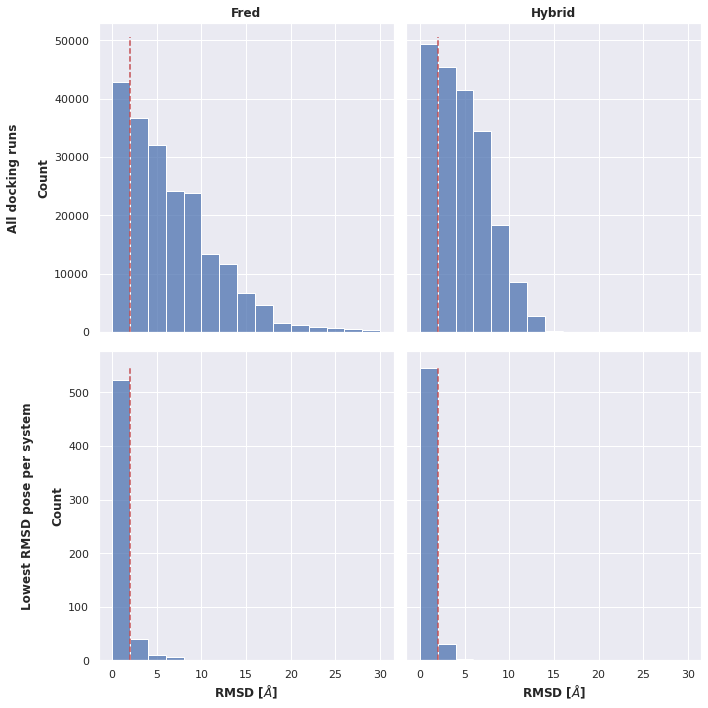

In [5]:
def plot_performance(fred_results, hybrid_results, n_bootstrap=1000, ci=0.95, directory=OUT_DIR):
    
    # 4 subplots
    fig, axes = plt.subplots(2, 2, sharey='row', sharex=True, figsize=(10, 10))
    
    # plot data
    bins = range(0, int(max(fred_results["rmsd"].max(), hybrid_results["rmsd"].max())), 2)
    sns.histplot(data=fred_results, x="rmsd", bins=bins, ax=axes[0][0])
    sns.histplot(data=hybrid_results, x="rmsd", bins=bins, ax=axes[0][1])
    
    # titles
    axes[0][0].set_ylabel("All docking runs\n\nCount", fontweight="bold")
    axes[0][0].set_title("Fred", fontweight="bold")
    axes[0][0].set_xlabel("")
    axes[0][1].set_title("Hybrid", fontweight="bold")
    axes[0][1].set_xlabel("")
    
    # plot 2 A cutoff
    axes[0][0].vlines(2, ymin=0, ymax=50500, colors="r", linestyles="dashed")
    axes[0][1].vlines(2, ymin=0, ymax=50500, colors="r", linestyles="dashed")
    
    # sort by rmsd and pick the lowest RMSD pose per system
    fred_results = fred_results.sort_values("rmsd")
    fred_results = fred_results.groupby(["ligand_pdb_id"]).head(1)
    hybrid_results = hybrid_results.sort_values("rmsd")
    hybrid_results = hybrid_results.groupby(["ligand_pdb_id"]).head(1)
    
    # plot data
    sns.histplot(data=fred_results, x="rmsd", bins=bins, ax=axes[1][0])
    sns.histplot(data=hybrid_results, x="rmsd", bins=bins, ax=axes[1][1])
    
    # titles
    axes[1][0].set_ylabel("Lowest RMSD pose per system\n\nCount", fontweight="bold")
    axes[1][0].set_xlabel("RMSD [$\AA$]", fontweight="bold")
    axes[1][1].set_xlabel("RMSD [$\AA$]", fontweight="bold")
    
    # plot 2 A cutoff
    axes[1][0].vlines(2, ymin=0, ymax=550, colors="r", linestyles="dashed")
    axes[1][1].vlines(2, ymin=0, ymax=550, colors="r", linestyles="dashed")
    
    plt.tight_layout()
    
plot_performance(fred_results, hybrid_results)

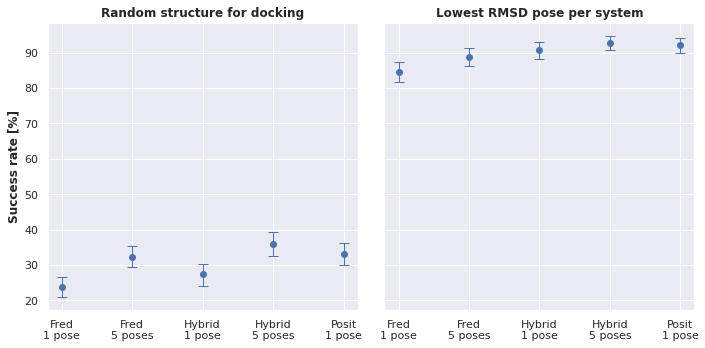

In [6]:
def plot_performance(fred_results, hybrid_results, posit_results, n_bootstrap=1000, ci=0.95, directory=OUT_DIR):
    
    # 2 subplots
    fig, axes = plt.subplots(1, 2, sharey='row', sharex=True, figsize=(10, 5))
    
    sampled_success_rates = []
    for i, focus in enumerate(["Random structure for docking", "Lowest RMSD pose per system"]):
        for method, results in zip(["Fred", "Hybrid", "Posit"], [fred_results, hybrid_results, posit_results]):
            for pose_mode in ["1 pose", "5 poses"]:
                if pose_mode == "1 pose":  # pick pose 1
                    result_selection = results[results["pose"] == 1]
                elif pose_mode == "5 poses":  # keep all poses
                    result_selection = results.copy()
                    if method == "Posit":  # generating multiple poses not possible
                        continue
                if focus == "Lowest RMSD pose per system":
                    result_selection = result_selection.sort_values("rmsd")
                    result_selection = result_selection.groupby(["ligand_pdb_id"]).head(1)
                    success_labels = (result_selection["rmsd"] <= 2).to_list()
                else:
                    if pose_mode == "5 poses":  # pick best pose per protein ligand pair
                        result_selection = result_selection.sort_values("rmsd")
                        result_selection = result_selection.groupby(["protein_pdb_id", "ligand_pdb_id"]).head(1)
                sampled_success_rates_i = []
                for _ in range(n_bootstrap):
                    if focus == "Lowest RMSD pose per system":
                        sampled_success_labels = resample(success_labels)
                    else:  # pick a random structure for docking per ligand
                        sampled_random_structures = result_selection.groupby("ligand_pdb_id").sample(n=1)
                        sampled_success_labels = (sampled_random_structures["rmsd"] <= 2).to_list()
                    sampled_success_rates_i.append((sum(sampled_success_labels) / len(sampled_success_labels)) * 100)
                sampled_success_rates_i = sorted(sampled_success_rates_i)
                mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
                cutoff = (1 - ci) / 2
                lower_bound = sampled_success_rates_i[int(n_bootstrap * cutoff)]
                upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + cutoff))]
                sampled_success_rates.append([focus, f"{method}\n{pose_mode}", mean, lower_bound, upper_bound])
        # plot sampled data
        sampled_success_rates_df = pd.DataFrame(
            sampled_success_rates, 
            columns=["focus", "method\npose_mode", "success_rate", "ci_lower", "ci_upper"]
        )
        sampled_success_rates_i = sampled_success_rates_df[sampled_success_rates_df["focus"] == focus]
        axes[i].errorbar(
            x=sampled_success_rates_i["method\npose_mode"],
            y=sampled_success_rates_i["success_rate"],
            yerr=[
                sampled_success_rates_i["success_rate"] - sampled_success_rates_i["ci_lower"], 
                sampled_success_rates_i["ci_upper"] - sampled_success_rates_i["success_rate"]
            ],
            fmt="o",
            elinewidth=1,
            capsize=5,
            capthick=1
        )
        axes[i].set_xlabel("", fontweight="bold")
        axes[i].set_title(focus, fontweight="bold")
    axes[0].set_ylabel("Success rate [%]", fontweight="bold")
    
    plt.tight_layout()
    plt.savefig(directory / "multiple_poses.png", dpi=300)
    
    return sampled_success_rates_df

sampled_success_rates = plot_performance(fred_results, hybrid_results, posit_results)

In [7]:
sampled_success_rates

,focus,method\npose_mode,success_rate,ci_lower,ci_upper
0,Random structure for docking,Fred\n1 pose,23.772666,21.052632,26.485569
1,Random structure for docking,Fred\n5 poses,32.335654,29.371817,35.483871
2,Random structure for docking,Hybrid\n1 pose,27.339219,24.108659,30.390492
3,Random structure for docking,Hybrid\n5 poses,35.998981,32.597623,39.388795
4,Random structure for docking,Posit\n1 pose,33.133616,29.881154,36.332767
5,Lowest RMSD pose per system,Fred\n1 pose,84.410017,81.663837,87.266553
6,Lowest RMSD pose per system,Fred\n5 poses,88.828353,86.078098,91.341256
7,Lowest RMSD pose per system,Hybrid\n1 pose,90.708829,88.285229,93.039049
8,Lowest RMSD pose per system,Hybrid\n5 poses,92.708149,90.662139,94.736842
9,Lowest RMSD pose per system,Posit\n1 pose,92.195246,89.813243,94.227504
